## DeepEntropyScaling Model Demo

In this notebook we show how easy it is to use the DeepEntropyScaling model.
Please install PyTorch and the feos package first.

The experimental references are freely available DDB data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json, toml
import os

from deep_entropy_scaling.nn_training import load_model0
from deep_entropy_scaling.utils import get_entropy
from deep_entropy_scaling.nn_dataset import dataset, minmax_to_json, minmax_from_json


### Load PC-SAFT parameters

At first we load the PC-SAFT parameters. The model is optimized using SAFT parameter from Winter. We recommend relying on parameters from this dataset. Especially when parameters are only optimised for one species, they can degenerate. Such parameters do not represent the underlying species properly and are not suited for predictions.

In [4]:
saft = pd.read_csv( "demo_data/saft_paras_demo.csv" )
saft

,names,molarweight,m,sigma,epsilon_k,mu,kappa_ab,epsilon_k_ab,isomeric_smiles
0,butan-1-ol,74.073,3.66387,3.24366,232.69184,0,0.01435,2163.47788,CCCCO


### Load data

Now we can load the data we want to predict viscosities for. We assume SI units i.e. temperature in K and pressure in Pascal. Furthermore we recommend to add state information about what phase a state point belongs to. Here all datapoints are in the liquid phase.

After loading the data we assign PC-SAFT parameters to every sample.

In [5]:
data_path = "demo_data/butanol_data.csv"

data = pd.read_csv(data_path)
para_cols = ['molarweight', 'm','sigma', 'epsilon_k', 'kappa_ab','epsilon_k_ab','mu']
for pcol in para_cols:
    data[pcol] = saft[pcol].iloc[0]

data = data.apply( get_entropy , axis=1 )
data["value"] = data["viscosity"]
data["log_value"] = np.log(data["viscosity"])
data['iupac_name'] = "butan-1-ol"
data['cas'] = "71-36-3" 
data['family'] = "n-alcohols"

#data.to_csv("demo_data/butanol_data.csv",index=False)

data.head()

,temperature,pressure,viscosity,state,Reference,density,names,molarweight,m,sigma,...,epsilon_k_ab,mu,resd_entropy,molar_density,value,log_value,iupac_name,cas,family,red_resd_entropy
0,203.15,10000,0.10900,liquid,3,NaN,butan-1-ol,74.073,3.66387,3.24366,...,2163.47788,0,15.916293,11953.764936,0.10900,-2.216407,butan-1-ol,71-36-3,n-alcohols,4.344121
1,203.15,500000,0.11042,liquid,3,NaN,butan-1-ol,74.073,3.66387,3.24366,...,2163.47788,0,15.921248,11956.971857,0.11042,-2.203464,butan-1-ol,71-36-3,n-alcohols,4.345473
2,203.15,1000000,0.11245,liquid,3,NaN,butan-1-ol,74.073,3.66387,3.24366,...,2163.47788,0,15.926299,11960.238568,0.11245,-2.185247,butan-1-ol,71-36-3,n-alcohols,4.346851
3,213.15,10000,0.05752,liquid,3,NaN,butan-1-ol,74.073,3.66387,3.24366,...,2163.47788,0,15.370306,11829.232351,0.05752,-2.855623,butan-1-ol,71-36-3,n-alcohols,4.195101
4,213.15,500000,0.05857,liquid,3,NaN,butan-1-ol,74.073,3.66387,3.24366,...,2163.47788,0,15.375184,11832.514309,0.05857,-2.837533,butan-1-ol,71-36-3,n-alcohols,4.196433


### Build and Load NN

Finally we can build our NN model with the optimized hyperparmeters. Then we load and apply the model weights.

In [6]:
path = "train71/"

with open(path+"best_result_config.json") as f:
    config = json.load(f)

config

{'val_loss': 5.363227683119476e-05,
 'val_l1': 0.0036629082169383764,
 'train_loss': 2.1686162654077634e-05,
 'train_l1': 0.002796189161017537,
 'epoch': 73,
 'i_re_best': '0',
 'timestamp': 1734230225,
 'checkpoint_dir_name': 'checkpoint_000000',
 'should_checkpoint': True,
 'done': True,
 'training_iteration': 1,
 'trial_id': 'e5144_00142',
 'date': '2024-12-15_03-37-05',
 'time_this_iter_s': 444.7897574901581,
 'time_total_s': 444.7897574901581,
 'pid': 4145084,
 'hostname': 'wolfgang-cpu04',
 'node_ip': '192.168.8.24',
 'config': {'lr': 0.001,
  'batch_size': 32,
  'n_layers_ref': 4,
  'n_nodes_ref': 36,
  'n_nodes_feature_ref': 36,
  'n_features_ref': 8,
  'n_features': 8,
  'n_layers_parameter': 2,
  'n_nodes_parameter': 82,
  'n_nodes_entropy_feature': 16},
 'time_since_restore': 444.7897574901581,
 'iterations_since_restore': 1,
 'experiment_tag': '142_batch_size=32,lr=0.0010,n_features=8,n_features_ref=8,n_layers_parameter=2,n_layers_ref=4,n_nodes_entropy_feature=16,n_nodes_fe

In [7]:
# you can either load a checkpoint pickle or a state dict
# load_model0 defaults to state_dict_path if no checkpoint is given
config["checkpoint_path"] = path+"checkpoint.pt"
config["checkpoint_path"] = ""
config["state_dict_path"] = path+"model_state_dict.json"

model = load_model0(config)

load0


### Build Dataset

After loading the data we can generate the dataset used for predictions.
Since the neural network operates with normalised inputs, the normalisation rules must be loaded and applied to the dataset. The polynomial features are also added. This all happens automatically.

In [8]:
y_features = ["log_value"]

scalerX = minmax_from_json(path+'Xscaler.json')
scalerY = minmax_from_json(path+'Yscaler.json')    

demo_data = dataset(data_path, y_features=y_features,
                             scalerX=scalerX, scalerY=scalerY, keepXY=True)

### Predict viscosities

Now we can use the model to predict viscosities. The model predicts the normed log of the viscosity in milli pascal seconds (mPas).

In [9]:
model.eval()
y_pred = model(demo_data.X_scaled).detach().numpy()
#y_pred = model.forward_ref(demo_data.X_scaled).detach().numpy()
#y_pred = model.forward(demo_data.X_scaled).detach().numpy()

tensor([0.4716, 0.4718, 0.4720, 0.4458, 0.4460, 0.4463, 0.4148, 0.4150, 0.4152,
        0.3895, 0.3898, 0.3900, 0.3524, 0.3527, 0.3529, 0.3173, 0.3174, 0.3176,
        0.2843, 0.2844, 0.2846, 0.2516, 0.2517, 0.2519, 0.2309, 0.2311, 0.2313,
        0.1978, 0.1979, 0.1981, 0.1785, 0.1787, 0.1550, 0.1552, 0.1367, 0.1370],
       grad_fn=<SumBackward1>) tensor([-0.0088, -0.0088, -0.0088, -0.0080, -0.0080, -0.0080, -0.0062, -0.0062,
        -0.0062, -0.0044, -0.0044, -0.0044, -0.0014, -0.0014, -0.0014,  0.0021,
         0.0021,  0.0021,  0.0037,  0.0037,  0.0037,  0.0062,  0.0062,  0.0062,
         0.0084,  0.0084,  0.0084,  0.0128,  0.0128,  0.0128,  0.0157,  0.0157,
         0.0190,  0.0190,  0.0217,  0.0217], grad_fn=<SumBackward1>)


### Compare Predictions with Experimental Results

The predictions can be compared to experimental results.

#### Agreement between prediction and experiment is good.


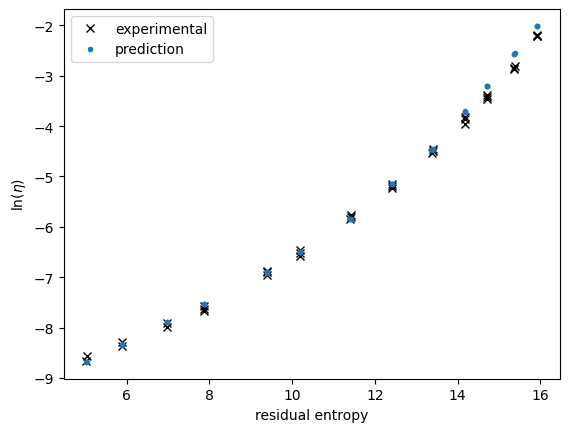

MEAD:  11.15 %


In [11]:
y  = np.squeeze( demo_data.scalerY.inverse_transform(y_pred) )
yy = np.exp( y )
y_exp = data["log_value"]
y_eexp = np.exp( y_exp )

plt.plot( data["resd_entropy"], y_exp, "kx", label="experimental" )
plt.plot( data["resd_entropy"], y, ".", label="prediction" )
plt.legend()
plt.xlabel("residual entropy")
plt.ylabel(r"ln($\eta$)")
plt.show()
plt.close()

#plt.plot( data["temperature"], y_exp, "kx", label="experimental" )
#plt.plot( data["temperature"], yy, ".", label="prediction" )
#plt.legend()
#plt.xlabel("temperature / K")
#plt.ylabel("viscosity / MPas")
#plt.show()
#plt.close()

dev =   (yy-y_eexp) / y_eexp

print("MEAD: ", round(np.mean( np.abs(dev) )*100,2), "%" )


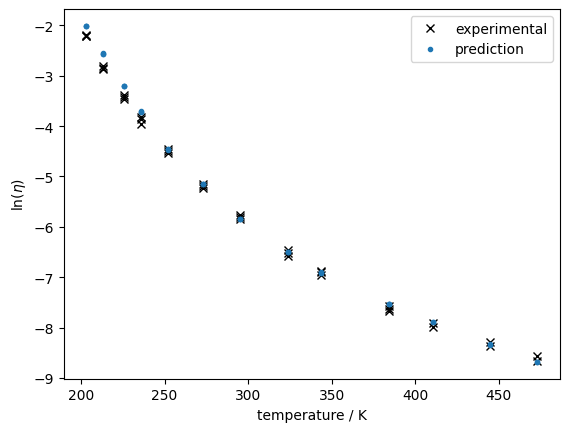

In [12]:
plt.plot( data["temperature"], y_exp, "kx", label="experimental" )
plt.plot( data["temperature"], y, ".", label="prediction" )
plt.legend()
plt.xlabel("temperature / K")
plt.ylabel(r"ln($\eta$)")
plt.show()
plt.close()